In [ ]:
# imports
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import xgboost as xgb 
import lightgbm as lgbm 

import descartes
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import tilemapbase

from math import sqrt
from scipy.stats import norm
from shapely.geometry import Point, Polygon 
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix 
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline as skpipe
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import SMOTE

import time # measure runtime
from time import time #used to check the time elapsed since running

from IPython import display

import re
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/lukasiwei/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
combined_df = pd.read_csv('datasets/combined_df_for_model.csv')

In [ ]:
combined_df.head()

,block,latitude,longitude,addressaccuracy,wnvpresent,tavg,dewpoint,wetbulb,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,pesticide,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHERS,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,street_ E 130TH ST,street_ E 138TH ST,street_ E 67TH ST,street_ E 91ST PL,street_ E 91ST ST,street_ E RANDOLPH ST,street_ N ASHLAND AVE,street_ N ASHLAND AVE OVERPASS,street_ N AUSTIN AVE,street_ N AVONDALE AVE,street_ N CALIFORNIA AVE,street_ N CAMPBELL AVE,street_ N CANNON DR,street_ N CENTRAL PARK DR,street_ N FRANCISCO AVE,street_ N HARLEM AVE,street_ N HUMBOLDT DR,street_ N KEDVALE AVE,street_ N LARAMIE AVE,street_ N LAWLER AVE,street_ N LEMONT AVE,street_ N LONG AVE,street_ N MANDELL AVE,street_ N MCCLELLAN AVE,street_ N MILWAUKEE AVE,street_ N MONT CLARE AVE,street_ N MOSELL AVE,street_ N OAK PARK AVE,street_ N OAKLEY AVE,street_ N OKETO AVE,street_ N PITTSBURGH AVE,street_ N PULASKI RD,street_ N RICHMOND ST,street_ N RIDGE AVE,street_ N RUTHERFORD AVE,street_ N SPRINGFIELD AVE,street_ N STAVE ST,street_ N STREETER DR,street_ N TRIPP AVE,street_ N WESTERN AVE,street_ S ARTESIAN AVE,street_ S ASHLAND AVE,street_ S AVENUE G,street_ S AVENUE L,street_ S BRANDON,street_ S CALIFORNIA,street_ S CALIFORNIA AVE,street_ S CARPENTER ST,street_ S CENTRAL AVE,street_ S CHICAGO AVE,street_ S CICERO AVE,street_ S CORNELL AVE,street_ S COTTAGE GROVE,street_ S DEARBORN ST,street_ S DOTY AVE,street_ S DR MARTIN LUTHER KING JR DR,street_ S EBERHART AVE,street_ S HAMLIN AVE,street_ S HOYNE AVE,street_ S KEDZIE AVE,street_ S KILPATRICK AVE,street_ S KOLMAR,street_ S KOSTNER AVE,street_ S LONGWOOD DR,street_ S MACKINAW,street_ S MELVINA AVE,street_ S MILLARD AVE,street_ S MUSKEGON AVE,street_ S NORDICA,street_ S PEORIA ST,street_ S PULASKI RD,street_ S RACINE AVE,street_ S SOUTH SHORE DR,street_ S STATE ST,street_ S STONY ISLAND AVE,street_ S THROOP,street_ S TORRENCE AVE,street_ S UNION AVE,street_ S VINCENNES,street_ S WALLACE ST,street_ S WESTERN AVE,street_ W 104TH ST,street_ W 113TH ST,street_ W 116TH ST,street_ W 127TH PL,street_ W 18TH ST,street_ W 31ST ST,street_ W 37TH PL.,street_ W 51ST ST,street_ W 63RD ST,street_ W 64TH ST,street_ W 65TH ST,street_ W 69TH ST,street_ W 72ND ST,street_ W 77TH ST,street_ W 85TH ST,street_ W 89TH ST,street_ W 95TH ST,street_ W ADDISON ST,street_ W AGATITE AVE,street_ W BALMORAL AVE,street_ W BELDEN AVE,street_ W CHICAGO,street_ W FARWELL AVE,street_ W FOSTER AVE,street_ W FULLERTON AVE,street_ W GARFIELD BLVD,street_ W GRAND AVE,street_ W GRANVILLE AVE,street_ W GREENLEAF AVE,street_ W HIGGINS AVE,street_ W HIGGINS RD,street_ W LELAND AVE,street_ W MONTANA ST,street_ W MONTROSE DR,street_ W OHARE,street_ W OHARE AIRPORT,street_ W PERSHING RD,street_ W ROOSEVELT,street_ W ROSCOE ST,street_ W STRONG ST,street_ W SUNNYSIDE AVE,street_ W WEBSTER AVE,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161

In [ ]:
combined_df.shape

(9601, 283)

## Modeling Preprocessing

In [ ]:
# define X and y
features = [col for col in combined_df if col != 'wnvpresent']
X = combined_df[features] 
y = combined_df['wnvpresent']

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)
print(X_train.shape)
print(X_test.shape)

(6720, 282)
(2881, 282)


In [ ]:
# define numeric features
numeric_features = ['block', 'latitude', 'longitude',
                           'addressaccuracy', 'tavg',
                           'dewpoint', 'wetbulb', 'preciptotal',
                           'stnpressure', 'sealevel', 'resultspeed',
                           'resultdir', 'avgspeed', 'year',
                           'month', 'day']

X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

In [ ]:
# define categorical features
X_train_categorical = X_train.drop(columns=numeric_features, axis=1)
X_test_categorical = X_test.drop(columns=numeric_features, axis=1)

In [ ]:
# scale transformation
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform( X_train_numeric )
X_test_numeric = scaler.transform( X_test_numeric )

In [ ]:
# create dataframe for numeric features
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_features)
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_features)

In [ ]:
X_train_numeric.head()

,block,latitude,longitude,addressaccuracy,tavg,dewpoint,wetbulb,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day
0,-1.114481,-1.129250,0.556560,-2.169851,0.766509,1.329638,1.106096,-0.379141,-0.379156,-0.508554,-0.762812,0.014829,-0.558996,-1.151710,0.256430,0.664999
1,-0.991177,-1.537472,1.529291,-2.169851,0.372626,-0.066462,0.088937,-0.389228,-0.642000,-0.508554,1.565937,0.546032,1.334630,0.552836,1.181892,-0.358727
2,1.269407,0.683807,-1.001427,0.046279,0.635214,1.075802,0.815479,-0.046268,-1.255303,-1.281799,-1.040872,-1.578778,0.175267,-1.151710,-0.669032,1.347482
3,0.529580,-0.412175,-0.660625,0.784989,0.372626,-0.066462,0.088937,-0.389228,-0.642000,-0.508554,1.565937,0.546032,1.334630,0.552836,1.181892,-0.358727
4,-1.032278,-1.585184,1.094179,-2.169851,0.766509,0.948883,0.815479,-0.026094,-0.379156,-0.422638,2.052541,0.227310,1.798375,-1.151710,1.181892,-1.041211


In [ ]:
# reset index
X_train_total = pd.concat([X_train_numeric.reset_index(drop=True), X_train_categorical.reset_index(drop=True)], axis=1)
X_test_total = pd.concat([X_test_numeric.reset_index(drop=True), X_test_categorical.reset_index(drop=True)], axis=1)

In [ ]:
# instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(DecisionTreeClassifier(), random_state=42),
          'gbm': GradientBoostingClassifier(random_state=42),
          'xgb': xgb.XGBClassifier(random_state=42), 
          'lgbm': lgbm.LGBMClassifier(random_state=42), 
          'dt': DecisionTreeClassifier(random_state=42), 
          'svc': SVC(random_state=42, probability=True),
          'nb': GaussianNB(),
          'knn': KNeighborsClassifier(n_neighbors=3)
        }

In [ ]:
# define resamplers
resamplers = {'smote': SMOTE(random_state=42),
              'adasyn': ADASYN(random_state=42),
             'None':None}

In [ ]:
def gscv_creator_3(model, pipe_params_1, pipe_params_2, pipe_params_3,resampler_1='smote', resampler_2='adasyn', n_jobs=-1):
    """
    function to instantiate models 
    parameters for gridsearching are prefixed correctly according to the dunder__ convention 
    """
    
    df_results = pd.DataFrame(
    columns = [
        'Classifier',
        'CV Score (train)',
        'ROC_AUC (train)',
        'ROC_AUC (test)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Sensitivity (test)',
        'Specificity (test)',
        'Precision (test)',
        'Recall (test)',
        'Misclassification (test)',
    ])
    
    # SMOTE
    
    pipe_1 = imbpipe([
            (resampler_1, resamplers[resampler_1]),
            (model, models[model]),
        ])
    
    gs_1 = GridSearchCV(pipe_1,
                      pipe_params_1,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers
    
    gs_1.fit(X_train_total, y_train)
    
    y_smote_pred = gs_1.predict(X_test_total)
    tn, fp, fn, tp = confusion_matrix(y_test, y_smote_pred).ravel()
    
    new_row_1 = [{
        'Classifier' : model + ' smote',
        'CV Score (train)' : round(gs_1.best_score_, 5),
        'ROC_AUC (train)': round(gs_1.score(X_train_total, y_train), 2),
        'ROC_AUC (test)' : round(gs_1.score(X_test_total, y_test) ,2 ),
        'Accuracy (train)': round(gs_1.score(X_train_total, y_train), 2),
        'Accuracy (test)' : round(gs_1.score(X_test_total, y_test) ,2 ),
        'Sensitivity (test)' : round (tp/(tp+fn), 2),
        'Specificity (test)' : round (tn/(tn+fp), 2),
        'Precision (test)' : round (tp/(tp+fp), 2),
        'Recall (test)' : round (tp/(tp+fn), 2),
        'Misclassification (test)' : round (1-(tp+tn)/(tn+fp+fn+tp),2),
    }]
    
    df_results = pd.concat([df_results, pd.DataFrame(new_row_1)], axis = 0)
    
    # ADASYN
    
    pipe_2 = imbpipe([
            (resampler_2, resamplers[resampler_2]),
            (model, models[model]),
        ])
    
    gs_2 = GridSearchCV(pipe_2,
                      pipe_params_2,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers
    
    gs_2.fit(X_train_total, y_train)
    
    y_adasyn_pred = gs_2.predict(X_test_total)
    tn, fp, fn, tp = confusion_matrix(y_test, y_adasyn_pred).ravel()
    
    new_row_2 = [{
        'Classifier' : model + ' adasyn',
        'CV Score (train)' : round(gs_2.best_score_, 5),
        'ROC_AUC (train)': round(gs_2.score(X_train_total, y_train), 2),
        'ROC_AUC (test)' : round(gs_2.score(X_test_total, y_test) ,2 ),
        'Accuracy (train)': round(gs_2.score(X_train_total, y_train), 2),
        'Accuracy (test)' : round(gs_2.score(X_test_total, y_test) ,2 ),
        'Sensitivity (test)' : round (tp/(tp+fn), 2),
        'Specificity (test)' : round (tn/(tn+fp), 2),
        'Precision (test)' : round (tp/(tp+fp), 2),
        'Recall (test)' : round (tp/(tp+fn), 2),
        'Misclassification (test)' : round (1-(tp+tn)/(tn+fp+fn+tp),2),
    }]
    
    df_results = pd.concat([df_results, pd.DataFrame(new_row_2)], axis = 0)
    
    # Without SMOTE or ADASYN
    
    pipe_3 = skpipe([
            (model, models[model])
        ])
    
    gs_3 = GridSearchCV(pipe_3,
                      pipe_params_3,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers
    
    gs_3.fit(X_train_total, y_train)
    
    y_no_pred = gs_3.predict(X_test_total)
    tn, fp, fn, tp = confusion_matrix(y_test, y_no_pred).ravel()
    
    new_row_3 = [{
        'Classifier' : model,
        'CV Score (train)' : round(gs_3.best_score_, 5),
        'ROC_AUC (train)': round(gs_3.score(X_train_total, y_train), 2),
        'ROC_AUC (test)' : round(gs_3.score(X_test_total, y_test) ,2 ),
        'Accuracy (train)': round(gs_3.score(X_train_total, y_train), 2),
        'Accuracy (test)' : round(gs_3.score(X_test_total, y_test) ,2 ),
        'Sensitivity (test)' : round (tp/(tp+fn), 2),
        'Specificity (test)' : round (tn/(tn+fp), 2),
        'Precision (test)' : round (tp/(tp+fp), 2),
        'Recall (test)' : round (tp/(tp+fn), 2),
        'Misclassification (test)' : round (1-(tp+tn)/(tn+fp+fn+tp),2),
    }]
    
    df_results = pd.concat([df_results, pd.DataFrame(new_row_3)], axis = 0)
    
    return df_results

## Models

### Basline Model: Gaussian Naive Bayes Classifier

In [ ]:
# NB with SMOTE
pipe_param_1 = {'smote__k_neighbors':[1,2,3,5,7],
                'nb__var_smoothing':[0.01,0.001,0.0001,0.000001,0.0000001]
               }

# NB with ADASYN
pipe_param_2 = {'adasyn__n_neighbors':[1],
                'nb__var_smoothing':[0.01,0.001,0.0001,0.000001,0.0000001]
               }

# NB w/o resamplers
pipe_param_3 = {
    'nb__var_smoothing':[0.01,0.001,0.0001,0.000001,0.0000001]
    }

gscv_creator_3(model='nb', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   15.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.7s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,nb smote,0.67539,0.72,0.64,0.72,0.64,0.92,0.23,0.06,0.92,0.73
0,nb adasyn,0.63295,0.69,0.60,0.69,0.60,0.86,0.25,0.06,0.86,0.72
0,nb,0.68389,0.77,0.67,0.77,0.67,0.76,0.51,0.08,0.76,0.48


### Logistic Regression Classifier

In [ ]:
# LogReg with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[2,3,5],
    'lr__C':[0.1, 1, 5],
    'lr__penalty': [None, 'l2'],
    'lr__solver': ['lbfgs', 'newton-cg', 'saga'],
}

# LogReg with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[1,2,3],
    'lr__C':[0.1, 1, 5],
    'lr__penalty': [None, 'l2'],
    'lr__solver': ['lbfgs', 'newton-cg', 'saga'],
}

# LogReg w/o resamplers
pipe_param_3 = {
    'lr__C':[0.1, 1, 5],
    'lr__penalty': [None, 'l2'],
    'lr__solver': ['lbfgs', 'newton-cg', 'saga'],
}

gscv_creator_3(model='lr', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.4min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.0min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   54.0s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,lr smote,0.75421,0.80,0.75,0.80,0.75,0.49,0.83,0.14,0.49,0.19
0,lr adasyn,0.75206,0.79,0.75,0.79,0.75,0.44,0.84,0.13,0.44,0.18
0,lr,0.76917,0.83,0.77,0.83,0.77,0.00,1.00,NaN,0.00,0.05


### Random Forests Classifier

In [ ]:
# Random Forests with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[2,3,5],
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,3,5]
}

# Random Forests with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[2,3,5],
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,3,5]
}

# Random Forests w/o resamplers
pipe_param_3 = {
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,3,5]
}

gscv_creator_3(model='rf', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.3min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.1min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.3s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,rf smote,0.82123,0.92,0.84,0.92,0.84,0.61,0.87,0.20,0.61,0.14
0,rf adasyn,0.82119,0.92,0.83,0.92,0.83,0.62,0.87,0.21,0.62,0.14
0,rf,0.82222,0.94,0.83,0.94,0.83,0.00,1.00,NaN,0.00,0.05


### Decision Tree Classifier

In [ ]:
# DT with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[2,3,5],
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[3,4,5,6],
    'dt__max_features':['auto', 'sqrt', 'log2']    
}

# DT with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[2,3,5],
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[3,4,5,6],
    'dt__max_features':['auto', 'sqrt', 'log2']
}

# DT w/o resamplers

pipe_param_3 = {
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[3,4,5,6],
    'dt__max_features':['auto', 'sqrt', 'log2']
}

gscv_creator_3(model='dt', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.3s finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.6min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,dt smote,0.68712,0.64,0.61,0.64,0.61,0.91,0.33,0.07,0.91,0.64
0,dt adasyn,0.70820,0.76,0.72,0.76,0.72,0.75,0.59,0.09,0.75,0.40
0,dt,0.66873,0.68,0.65,0.68,0.65,0.00,1.00,0.00,0.00,0.05


### Extra Trees Classifier

In [ ]:
#ExtraTreesClassifier with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[2,3,5],
    'et__n_estimators': [100,200],
    'et__max_depth':[None, 3, 5],
    'et__min_samples_leaf':[1,2,5],
}

#ExtraTreesClassifier with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[1,2,3],
    'et__n_estimators': [100,200],
    'et__max_depth':[None, 3, 5],
    'et__min_samples_leaf':[1,2,5],
}

#ExtraTreesClassifier w/o resamplers
pipe_param_3 = {
    'et__n_estimators': [100,200],
    'et__max_depth':[None, 3, 5],
    'et__min_samples_leaf':[1,2,5],
}

gscv_creator_3(model='et', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.2min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.3min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.4s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,et smote,0.79594,0.92,0.79,0.92,0.79,0.46,0.87,0.17,0.46,0.15
0,et adasyn,0.79505,0.91,0.80,0.91,0.80,0.49,0.87,0.17,0.49,0.15
0,et,0.80263,0.96,0.81,0.96,0.81,0.00,1.00,NaN,0.00,0.05


### Light Gradient Boosting Machine (LGBM) Classifier 

In [ ]:
# LGBM with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[3, 5],
    'lgbm__objective':['binary'],
    'lgbm__max_depth':[1, 3],
    'lgbm__subsample':[0.7], 
    'lgbm__learning_rate':[0.1,0.5],
    'lgbm__n_estimators':[20,30],
    'lgbm__min_child_samples':[10,20],
    'lgbm__num_leaves':[6,13]
}

# LGBM with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[5],
    'lgbm__objective':['binary'],
    'lgbm__max_depth':[1, 3],
    'lgbm__subsample':[0.7], 
    'lgbm__learning_rate':[0.1,0.5],
    'lgbm__n_estimators':[20,30],
    'lgbm__min_child_samples':[10,20],
    'lgbm__num_leaves':[6,13]
}

# LGBM w/o resamplers
pipe_param_3 = {
    'lgbm__objective':['binary'],
    'lgbm__max_depth':[1, 3],
    'lgbm__subsample':[0.7], 
    'lgbm__learning_rate':[0.1,0.5],
    'lgbm__n_estimators':[20,30],
    'lgbm__min_child_samples':[10,20],
    'lgbm__num_leaves':[6,13]
}

gscv_creator_3(model='lgbm', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   31.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   40.7s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.8s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,lgbm smote,0.81954,0.87,0.82,0.87,0.82,0.62,0.86,0.20,0.62,0.15
0,lgbm adasyn,0.81919,0.87,0.83,0.87,0.83,0.56,0.87,0.19,0.56,0.15
0,lgbm,0.83026,0.87,0.83,0.87,0.83,0.00,1.00,NaN,0.00,0.05


### K-Nearest Neighbors Classifier

In [ ]:
# KNN with SMOTE (Set up pipe parameters)

pipe_param_1 = {'smote__k_neighbors':[1,3,5],
                'knn__n_neighbors':[1,2,5,7]
               }

# KNN with ADASYN
pipe_param_2 = {'adasyn__n_neighbors':[1,3,5],
                'knn__n_neighbors':[1,2,5,7]
               }

# KNN w/o resamplers
pipe_param_3 = {'knn__n_neighbors':[1,2,5,7]}

gscv_creator_3(model='knn', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   39.5s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   45.9s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.9s finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,knn smote,0.74984,0.93,0.76,0.93,0.76,0.79,0.66,0.11,0.79,0.34
0,knn adasyn,0.74439,0.93,0.76,0.93,0.76,0.78,0.66,0.11,0.78,0.33
0,knn,0.71657,0.93,0.73,0.93,0.73,0.05,0.99,0.35,0.05,0.05


### Gradient Boosting Model

In [ ]:
# GBM with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[3,5],
    'gbm__min_samples_split':range(200,1001,200),
    'gbm__max_depth':range(5,16,2),

}

# GBM with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[3,5],
    'gbm__min_samples_split':range(200,1001,200),
    'gbm__max_depth':range(5,16,2),

}

# GBM w/o resamplers
pipe_param_3 = {
    'gbm__min_samples_split':range(200,1001,200),
    'gbm__max_depth':range(5,16,2),
   
}

gscv_creator_3(model='gbm', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.8min finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.6min finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.7min finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,gbm smote,0.82392,0.91,0.84,0.91,0.84,0.38,0.93,0.22,0.38,0.10
0,gbm adasyn,0.82333,0.91,0.84,0.91,0.84,0.41,0.92,0.22,0.41,0.11
0,gbm,0.83717,0.92,0.85,0.92,0.85,0.02,1.00,0.25,0.02,0.05


### XGBoost (Extreme Gradient Boosting) Model

In [ ]:
# XGB with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[3,5],
    'xgb__objective':['binary:logistic'],
    'xgb__max_depth':[None, 2, 3],
    'xgb__subsample':[0.5], #prevent overfitting
    'xgb__learning_rate':[0.9,0.5, 0.1],
    'xgb__n_estimators':[200,300],

}

# XGB with Adasyn
pipe_param_2 = {
    'adasyn__n_neighbors':[3,5],
    'xgb__objective':['binary:logistic'],
    'xgb__max_depth':[None, 2, 3],
    'xgb__subsample':[0.5], #prevent overfitting
    'xgb__learning_rate':[0.9,0.5, 0.1],
    'xgb__n_estimators':[200,300],

}

# XGB w/o resamplers
pipe_param_3 = {
    'xgb__objective':['binary:logistic'],
    'xgb__max_depth':[None, 2, 3],
    'xgb__subsample':[0.5], #prevent overfitting
    'xgb__learning_rate':[0.9,0.5, 0.1],
    'xgb__n_estimators':[200,300]
   
}

gscv_creator_3(model='xgb', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 26.9min finished


[23:31:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 26.7min finished


[23:57:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.0min finished


[00:05:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,xgb smote,0.82092,0.87,0.83,0.87,0.83,0.62,0.86,0.20,0.62,0.15
0,xgb adasyn,0.82119,0.88,0.83,0.88,0.83,0.53,0.89,0.21,0.53,0.13
0,xgb,0.83548,0.90,0.85,0.90,0.85,0.04,1.00,0.46,0.04,0.05


### Support Vector Machine Classifier

In [ ]:
# svm with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[3, 5],
    'svc__C':[0.1, 1, 5],
    'svc__kernel':['rbf', 'poly'],
#    'svc__degree':[1, 5],
#    'svc__gamma':[1, 5]

}

# svm with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[3, 5],
    'svc__C':[0.1, 1, 5],
    'svc__kernel':['rbf', 'poly'],
#    'svc__degree':[1, 5],
#    'svc__gamma':[1, 5]
}

# svm w/o resamplers
pipe_param_3 = {
    'svc__C':[0.1, 1, 5],
    'svc__kernel':['rbf', 'poly'],
#    'svc__degree':[1, 5],
#    'svc__gamma':[1, 5]
   
}

gscv_creator_3(model='svc', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 41.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 40.8min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,svc smote,0.81365,0.88,0.82,0.88,0.82,0.69,0.84,0.19,0.69,0.17
0,svc adasyn,0.81431,0.88,0.82,0.88,0.82,0.67,0.84,0.19,0.67,0.17
0,svc,0.78063,0.97,0.80,0.97,0.80,0.00,1.00,NaN,0.00,0.05


### AdaBoost Classifier

In [ ]:
#AdaBoostClassifier with SMOTE
pipe_param_1 = {
    'smote__k_neighbors':[2,3,5],
    'ada__base_estimator__max_depth':[None,3,5],
    'ada__n_estimators':[20,40,80,100],
    'ada__learning_rate':[0.8,1.0],
}

#AdaBoostClassifier with ADASYN
pipe_param_2 = {
    'adasyn__n_neighbors':[1,2,3],
    'ada__base_estimator__max_depth':[None,3,5],
    'ada__n_estimators':[20,40,80,100],
    'ada__learning_rate':[0.8,1.0],
}

#AdaBoostClassifier w/o resamplers
pipe_param_3 = {
    'ada__base_estimator__max_depth':[None,3,5],
    'ada__n_estimators':[20,40,80,100],
    'ada__learning_rate':[0.8,1.0],
}

gscv_creator_3(model='ada', pipe_params_1 = pipe_param_1, pipe_params_2 = pipe_param_2, pipe_params_3 = pipe_param_3, 
               resampler_1='smote', resampler_2='adasyn', n_jobs=-1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.1min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.0min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,ada smote,0.78132,0.89,0.80,0.89,0.80,0.46,0.88,0.17,0.46,0.15
0,ada adasyn,0.78311,0.89,0.79,0.89,0.79,0.51,0.88,0.19,0.51,0.14
0,ada,0.77658,0.91,0.79,0.91,0.79,0.05,0.99,0.30,0.05,0.06


# Modelling Results

Classifier|CV Score (train)|ROC_AUC (train)|ROC_AUC (test)|Accuracy (train)|Accuracy (test)|Sensitivity (test)|Specificity (test|Precision (test)|Recall (test)|Misclassification (test)| F1 Score)
|---|---|---|---|---|---|---|---|---|---|---|---|
|Gaussian Naive Bayes|0.6838|0.77|0.67|0.77|0.67|0.76|0.51|0.08|0.76|0.48|
|Gaussian Naive Bayes (SMOTE)|0.6753|0.72|0.64|0.72|0.64|0.92|0.23|0.06|0.92|0.73|
|Gaussian Naive Bayes (ADASYN)|0.6329|0.69|0.60|0.69|0.60|0.86|0.25|0.06|0.86|0.72|
|Logistic Regression|0.76917|0.83|0.77|0.83|0.77|0.00|1.00|NaN|0.00|0.05|
|Logistic Regression (SMOTE)|0.7542|0.80|0.75|0.80|0.75|0.49|0.83|0.14|0.49|0.19|
|Logistic Regression (ADASYN)|0.7520|0.79|0.75|0.79|0.75|0.44|0.84|0.13|0.44|0.18|
|Random Forest|0.8222|0.94|0.83|0.94|0.83|0.00|1.0|NaN|0.00|0.05|
|Random Forest (SMOTE)|0.8212|0.92|0.84|0.92|0.84|0.61|0.87|0.20|0.61|0.14|
|Random Forest (ADASYN)|0.8211|0.92|0.83|0.92|0.83|0.62|0.87|0.21|0.62|0.14|
|Decision Tree|0.6687|0.68|0.65|0.68|0.65|0.00|1.00|0.00|0.00|0.05|
|Decision Tree (SMOTE)|0.6871|0.64|0.61|0.64|0.61|0.91|0.33|0.07|0.91|0.64|
|Decision Tree (ADASYN)|0.7082|0.76|0.72|0.76|0.72|0.75|0.59|0.09|0.75|0.40|
|Extra Trees|0.8026|0.96|0.81|0.96|0.81|0.00|1.00|NaN|0.00|0.05|
|Extra Trees (SMOTE)|0.7959|0.92|0.79|0.92|0.79|0.46|0.87|0.17|0.46|0.15|
|Extra Trees (ADASYN)|0.7950|0.91|0.80|0.91|0.80|0.49|0.87|0.17|0.49|0.15|
|Light Gradient Boost|0.8302|0.87|0.83|0.87|0.83|0.00|1.00|NaN|0.00|0.05|
|Light Gradient Boost (SMOTE)|0.8195|0.87|0.82|0.87|0.82|0.62|0.86|0.20|0.62|0.15|
|Light Gradient Boost (ADASYN)|0.8191|0.87|0.83|0.87|0.83|0.56|0.87|0.19|0.56|0.15|
|K-Nearest Neighbours|0.7165|0.93|0.73|0.93|0.73|0.05|0.99|0.35|0.05|0.05|
|K-Nearest Neighbours (SMOTE)|0.7498|0.93|0.76|0.93|0.76|0.79|0.66|0.11|0.79|0.34|
|K-Nearest Neighbours (ADASYN)|0.7443|0.93|0.73|0.93|0.76|0.78|0.66|0.11|0.78|0.33|
|Gradient Boosting|0.8371|0.92|0.85|0.92|0.85|0.02|1.00|0.25|0.02|0.05|
|Gradient Boosting (SMOTE)|0.8239|0.91|0.84|0.91|0.84|0.38|0.93|0.22|0.38|0.10|
|Gradient Boosting (ADASYN)|0.8233|0.91|0.84|0.91|0.84|0.41|0.92|0.22|0.41|0.11|
|XG Boost|0.8354|0.90|0.85|0.90|0.85|0.04|1.00|0.46|0.04|0.05|
|XG Boost (SMOTE)|0.8209|0.87|0.83|0.87|0.83|0.62|0.86|0.20|0.62|0.15||
|XG Boost (ADASYN)|0.8211|0.88|0.83|0.88|0.83|0.53|0.89|0.21|0.53|0.13|
|Support Vector|0.7806|0.97|0.80|0.97|0.80|0.00|1.00|NaN|0.00|0.05|
|Support Vector (SMOTE)|0.8136|0.88|0.82|0.88|0.82|0.69|0.84|0.19|0.69|0.17|
|Support Vector (ADASYN)|0.8143|0.88|0.82|0.88|0.82|0.67|0.84|0.19|0.67|0.17|
|ADABoost|0.7765|0.91|0.79|0.91|0.79|0.05|0.99|0.30|0.05|0.06|
|ADABoost (SMOTE)|0.7813|0.89|0.80|0.89|0.80|0.46|0.88|0.17|0.46|0.15|
|ADABoost (ADASYN)|0.7831|0.89|0.79|0.89|0.79|0.51|0.88|0.19|0.51|0.14|


Here, we add a new column that calculates the F1-score. F1-score is the Harmonic mean of the Precision and Recall. The formula is: 2 multiplied to the multiplication of precision and recall, divided by the sum of precision and recall. 

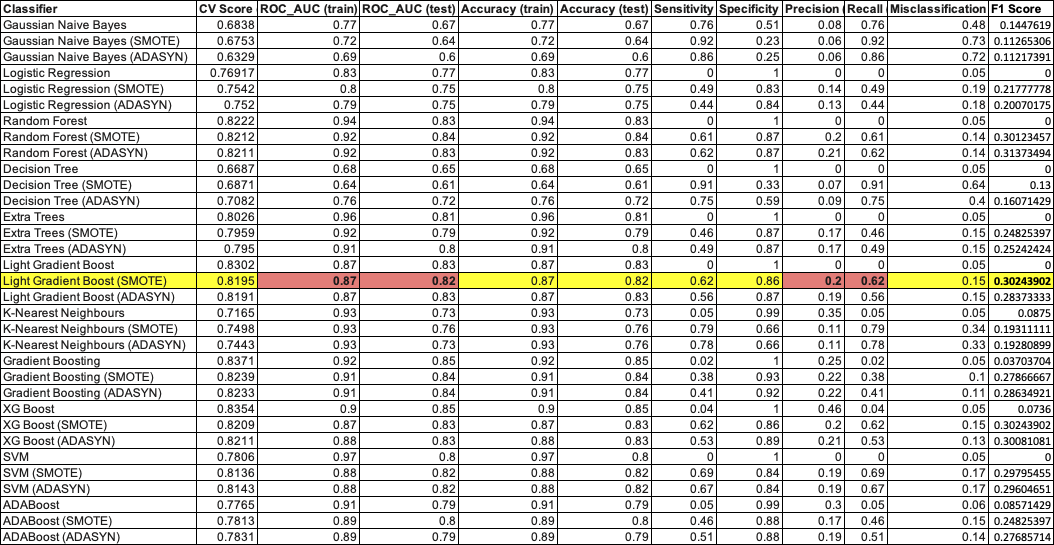

In [ ]:
from IPython import display
display.Image("media/model_comparison_table.png")

As mentioned above, the metrics we are using to evaluate the models are 
1. ROC_AUC: which tells us how well the model can distinguish between classes
2. Precision and Recall: Tells us how well our model identifies True Positives  
Based on these metrics, our final chosen model is the Light Gradient Boost (SMOTE) as it had high ROC_AUC scores, of which the train (0.87) and test scores (0.82) are both high. The precision (0.2) and recall (0.62) scores and the F1 score () is also higher compared to most models, with a low misclassification rate of 0.15. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=60b14a4f-b63c-4fa7-9c07-6649311f1d98' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>